# Import Dependencies

In [12]:
import mesa
import numpy as np
import math
import networkx as nx


import matplotlib.pyplot as plt
%matplotlib inline

# Helper Functions

In [13]:
def get_distance(pos_1, pos_2):
    '''
    Calculate the Euclidean distance between two positions

    used in trade.move()
    '''
    x1, y1 = pos_1
    x2, y2 = pos_2
    dx = x1 - x2
    dy = y1 - y2
    return math.sqrt(dx**2 + dy**2)

def flatten(list_of_lists):
    '''
    helper function for model datacollector for trade price
    collapses agent price list into one list
    '''
    return [item for sublist in list_of_lists for item in sublist]

def geometric_mean(list_of_prices):
    '''
    Find the geometric mean from a list of prices
    '''
    return np.exp(np.log(list_of_prices).mean())

def get_trade(agent):
    '''
    Return agent trade partners and non for other agents
    '''
    if type(agent) == Trader:
        return agent.trade_partners
    else: return None

# Resource Classes

In [14]:
class Sugar(mesa.Agent):
    '''
    Sugar:
    - contains an amount of sugar
    - grows one amount of sugar each turn
    '''
    def __init__(self, unique_id, model, pos, max_sugar):
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = max_sugar
        self.max_sugar = max_sugar

    def step(self):
        '''
        Sugar Growth Function, Adds one unit of sugar each step until
        we reach max amount of sugar
        '''
        self.amount = min([self.max_sugar, self.amount + 1]) # Either max amount or add one, whichever is less

In [15]:
class Spice(mesa.Agent):
    '''
    Spice:
    - contains an amount of spice
    - grows 1 amount of spice each turn
    '''
    def __init__(self, unique_id, model, pos, max_spice):
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = max_spice
        self.max_spice = max_spice

    def step(self):
        '''
        Spice Growth Function, adds one unit of spice 
        '''
        self.amount = min([self.max_spice, self.amount+1])
        # print(self.unique_id, self.max_spice, self.amount)


# Trader Class

In [16]:
class Trader(mesa.Agent):
    '''
    Trader:
    - has a metabolism for sugar and spice
    - harvests and trades sugar and spice to survive and thrive
    '''
    def __init__(self, unique_id, model, pos, moore=False, sugar=0, spice=0, metabolism_sugar=0, metabolism_spice=0, vision=0):
        super().__init__(unique_id, model)
        self.pos = pos
        self.moore = moore # Which grid are they looking at - could learn more about
        self.sugar = sugar
        self.spice = spice
        self.metabolism_sugar = metabolism_sugar
        self.metabolism_spice = metabolism_spice
        self.vision = vision
        self.prices = []
        self.trade_partners = []


    def get_sugar(self, pos):
        '''
        Used in self.get_sugar_amount()
        '''
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if type(agent) is Sugar:
                return agent
        return None

    def get_sugar_amount(self, pos):
        '''
        Used in self.move() as part of self.calculate_welfare()
        '''
        sugar_patch = self.get_sugar(pos)
        if sugar_patch:
            return sugar_patch.amount
        return 0
    
    def get_spice(self, pos):
        '''
        Used in self.get_spice_amount
        '''
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if type(agent) is Spice:
                return agent
        return None
    
    def get_spice_amount(self, pos):
        '''
        Used in self.move() as part of self.calculate_welfare()
        '''
        spice_patch = self.get_spice(pos)
        if spice_patch:
            return spice_patch.amount
        return 0
    
    def get_trader(self, pos):
        '''
        Helper function used in self.trader_with_neighbors()
        '''
        this_cell = self.model.grid.get_cell_list_contents(pos)

        for agent in this_cell:
            if isinstance(agent, Trader):
                return agent

    def is_occupied_by_other(self, pos):
        '''
        Helper function for 1. Identify every possible move an agent could make
        '''
        if pos == self.pos:
            # Agents position is considered unoccupied as agent can stay there
            return False
        
        # Get the contents of each cell in neighborhood
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for a in this_cell:
            # See if occupied by another agent
            if isinstance(a, Trader):
                return True
        return False
    
    def calculate_welfare(self, sugar, spice):
        '''
        Helper function 2. Maximize welfare for an agent
        '''
        # Calculate total resources agent has
        m_total = self.metabolism_sugar + self.metabolism_spice
        
        # Cobb-Douglas Function
        return sugar**(self.metabolism_sugar/m_total) * spice**(self.metabolism_spice/m_total)
    
    def is_starved(self):
        '''
        Helper function for self.maybe_die()
        '''
        return (self.sugar <= 0) or (self.spice <= 0)
    
    def calculate_MRS(self):
        '''
        Helper function for self.trade()

        Determine what the agent needs and what its willing to give up - between sugar and spice
        '''
        # If greater than one, excess of spice
        # If less than one, need more spice
        return (self.spice/self.metabolism_spice) / (self.sugar/self.metabolism_sugar)
        # return (spice/self.metabolism_spice) / (sugar/self.metabolism_sugar)
    
    def calculate_sell_spice_amount(self, price):
        '''
        Helper function for maybe_sell_spice.

        Determines how much sugar/spice is being traded in exchange for spice/sugar
        '''
        if price >= 1:
            sugar = 1
            spice = int(price)
        else:
            sugar = int(1/price)
            spice = 1
        return sugar, spice
    
    def sell_spice(self, other, sugar, spice):
        '''
        Used in maybe_sell_spice to actually exchange goods.
        '''
        self.sugar += sugar
        other.sugar -= sugar
        self.spice -= spice
        other.spice += spice
    
    def maybe_sell_spice(self, other, price, welfare_self, welfare_other):
        '''
        Helper fucntion for self.trade()
        '''

        sugar_exchanged, spice_exchanged = self. calculate_sell_spice_amount(price)

        # Does a trade make sense, does it benefit both parties?
        self_sugar = self.sugar + sugar_exchanged
        other_sugar = other.sugar - sugar_exchanged
        self_spice = self.spice - spice_exchanged
        other_spice = other.spice + spice_exchanged

        # Double check to ensure agents have resources
        # If not enough resources after, do not do the trade
        if ((self_sugar <= 0) or (other_sugar <= 0) or (self_spice <= 0) or (other_spice <=0)):
            return False
        
        # Trade Criteria One: Are the agents better off? True or False
        both_agents_are_better_off = ((welfare_self < self.calculate_welfare(self_sugar, self_spice)) and 
                                      (welfare_other < other.calculate_welfare(other_sugar, other_spice)))
        
        # Trade Criteria Two: Is their MRS Crossing? True or False
        mrs_not_crossing = self.calculate_MRS() > other.calculate_MRS()

        # print(both_agents_are_better_off, mrs_not_crossing)

        # Sale did not happen
        if not (both_agents_are_better_off and mrs_not_crossing):
            return False
        
        # Sale did happen, criteria met, so execute the exchange of goods
        self.sell_spice(other, sugar_exchanged, spice_exchanged)

        return True

    def trade(self, other): # Other is another trader
        '''
        Helper function used in trade_with_neighbors()

        Trade between two agents
        '''
        # print(f"Trade attempt: Agent {self.unique_id} (sugar:{self.sugar}, spice:{self.spice}, met_sugar:{self.metabolism_sugar}, met_spice:{self.metabolism_spice}) with Agent {other.unique_id} (sugar:{other.sugar}, spice:{other.spice}, met_sugar:{other.metabolism_sugar}, met_spice:{other.metabolism_spice})")
        # Check if any agent has non-positive resources - Replaced the one in the code because it was causing me errors.
        if self.sugar <= 0 or self.spice <= 0 or other.sugar <= 0 or other.spice <= 0:
            print(f"Trade blocked - insufficient resources")
            return

        # Agents will values spice and sugar differently from each other
        # Marginal Rate of Substitution between sugar and spice
        mrs_self = self.calculate_MRS()
        mrs_other = other.calculate_MRS()

        # print(f"MRS self: {mrs_self}, MRS other: {mrs_other}, mrs_self > mrs_other: {mrs_self > mrs_other}")

        # Calculate each agents welfare
        welfare_self = self.calculate_welfare(self.sugar, self.spice)
        welfare_other = other.calculate_welfare(other.sugar, other.spice)

        if math.isclose(mrs_self, mrs_other):
            return
        
        # Calculate Price
        price = math.sqrt(mrs_self*mrs_other)
            
        if mrs_self > mrs_other:
            # Self is a sugar buyer and spice seller
            sold = self.maybe_sell_spice(other, price, welfare_self, welfare_other)
            # No trade, criter not met
            if not sold:
                return
        else:
            # Self is a spice buyer and sugar seller
            # Inverse the direction rather than making a new maybe_sell_sugar function
            sold = self.maybe_sell_spice(self, price, welfare_other, welfare_self)
            if not sold:
                return
            
        # Capture data from the trade
        self.prices.append(price)
        self.trade_partners.append(other.unique_id)

        # Continue trading
        self.trade(other)


    # Build the move function for the Trader
    def move(self):
        '''
        Function for trader agent to identify the optimal move location for each step in 4 parts:
            1. Identify every possible move an agent could make
            2. Determine which move maximizes welfare for the agent
            3. Find closest and best option
            4. Move to that option
        '''
        # 1. Identify all possible moves an agent could make
        neighbors = [i
                     for i in self.model.grid.get_neighborhood( # Get neighborhood from the grid that we created (50x50 sugar and spice scape)
                         self.pos, self.moore, True, self.vision # True refers to set center, set all things to what we want
                     ) if not self.is_occupied_by_other(i)]
        
        # 2. Determine which move maximizes the welfare for the agent
        welfares = [
            self.calculate_welfare(self.sugar + self.get_sugar_amount(pos), self.spice + self.get_spice_amount(pos)) for pos in neighbors
        ]

        # 3. Find the closest best option
        # Get the highest welfare in welfares
        max_welfare = max(welfares)

        # Get the index of max welfare cells - potential places to move
        candidate_indices = [i for i in range(len(welfares))
                             if math.isclose(welfares[i], max_welfare)]
        
        # Convert index to positions of those cells, where the agent can move
        candidates = [neighbors[i] for i in candidate_indices]

        min_dist = min(get_distance(self.pos, pos) for pos in candidates)

        final_candidates = [pos for pos in candidates if math.isclose(get_distance(self.pos, pos), min_dist, rel_tol=1e-02)]

        self.random.shuffle(final_candidates)

        # 4. Finally, actually move the agent
        self.model.grid.move_agent(self, final_candidates[0])

        # print(min_dist, final_candidates, max_welfare)
        # print(welfares)
        # print(self.pos, neighbors)

    def eat(self):
        '''
        Function for agents to get local resources and consume sugar and spice
        '''
        # Get the amount of sugar on current position
        sugar_patch = self.get_sugar(self.pos)

        # If sugar is on the position, add it to the traders total
        # Then take away sugar according to metabolism
        if sugar_patch:
            self.sugar += sugar_patch.amount
            sugar_patch.amount = 0
        self.sugar -= self.metabolism_sugar

        # Same for spice
        spice_patch = self.get_spice(self.pos)

        if spice_patch:
            self.spice += spice_patch.amount
            spice_patch.amount = 0
        self.spice -= self.metabolism_spice

        # print(self.sugar, self.spice)

    def maybe_die(self):
        '''
        Function to remove Traders who have consumed all their sugar or spice
        '''
        if self.is_starved():
            # print(self.unique_id, self.model.schedule.get_type_count(Trader))
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            # print(self.unique_id, self.model.schedule.get_type_count(Trader))

    def trade_with_neighbors(self):
        '''
        Function for trader agents to decide who to trade with in 3 parts:
        1. Identify neighbors who can trade
        2. Trade
        3. Collect data of the trade
        '''
        neighbor_agents = [self.get_trader(pos) for pos in self.model.grid.get_neighborhood(
            self.pos, self.moore, False, self.vision) if self.is_occupied_by_other(pos)
        ]

        # If no neighbors to trade with:
        if len(neighbor_agents) == 0:
            return

        # Iterate through traders in neighboring cells to then trade
        for a in neighbor_agents:
            if a:
                self.trade(a)

        return 

# Model Class

In [17]:
class SugarscapeG1mt(mesa.Model):
    '''
    A model class to manage Sugarscape with Traders (G1mt)
    from Growing Artificial Societies by Axtell and Epstein
    '''
    def __init__(self, 
                 width=50, 
                 height=50, 
                 initial_population=200, # All new parameters according to the Growing Artificial Societies
                 endowment_min=25, 
                 endowment_max=50, 
                 metabolism_min=1, 
                 metabolism_max=5, 
                 vision_min=1, 
                 vision_max=5):
        # Initiate width and height of sugarscape - the 50x50 grid
        self.width = width
        self.height = height
        # Initiate population attributes - we need mins and maxs because we want a heterogenous population, which is similar to real life.
        # This allows for a diverse population which allows for variance in metabolism, vision, etc.
        self.initial_population = initial_population
        self.endowment_min = endowment_min
        self.endowment_max = endowment_max
        self.metabolism_min = metabolism_min
        self.metabolism_max = metabolism_max
        self.vision_min = vision_min
        self.vision_max = vision_max
        self.running = True

        #initiate activation schedule
        self.schedule = mesa.time.RandomActivationByType(self)
        #initiate mesa grid class
        self.grid = mesa.space.MultiGrid(self.width, self.height, torus=False)

        # Initiate data collector
        self.datacollector = mesa.DataCollector(
                model_reporters = {"Trader": lambda m: m.schedule.get_type_count(Trader),
                 "Trade Volume": lambda m: sum(len(a.trade_partners) for a in m.schedule.agents_by_type[Trader].values()),
                 "Price": lambda m: geometric_mean(flatten([a.prices for a in m.schedule.agents_by_type[Trader].values()]))},
                agent_reporters = {"Trade Network": lambda a: get_trade(a)}

        )

        # Read in landscape file from supplementary material
        sugar_distribution = np.genfromtxt('sugar-map.txt')
        spice_distribution = np.flip(sugar_distribution, 1) # Flip on x and y axis
        # print(sugar_distribution.shape)
        # print(sugar_distribution[30][15]) # Call specific cell (x,y)
        # plt.imshow(spice_distribution, origin='lower')

        agent_id = 0

        for _, x, y in self.grid.coord_iter():
            max_sugar = sugar_distribution[x,y]
            if max_sugar > 0:
                sugar = Sugar(agent_id, self, (x,y), max_sugar)
                self.grid.place_agent(sugar, (x,y))
                self.schedule.add(sugar)
                agent_id += 1

            max_spice = spice_distribution[x, y]
            if max_spice > 0:
                spice = Spice(agent_id, self, (x, y), max_spice)
                self.grid.place_agent(spice, (x, y))
                self.schedule.add(spice)
                agent_id += 1

        for i in range(self.initial_population):

            # Get each of the agent positions
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)

            # Give agents their initial endowment - Random number between min and max for heterogenous behavior
            sugar = int(self.random.uniform(self.endowment_min, self.endowment_max + 1))
            spice = int(self.random.uniform(self.endowment_min, self.endowment_max + 1))

            # Give agents initial metabolism - How much sugar and spice does each agent need - if they do not fill their metabolism, they will die
            metabolism_sugar = int(self.random.uniform(self.metabolism_min, self.metabolism_max + 1))
            metabolism_spice = int(self.random.uniform(self.metabolism_min, self.metabolism_max + 1))

            # Give agents vision
            vision = int(self.random.uniform(self.vision_min, self.vision_max + 1))

            # Create Trader object
            trader = Trader(
                agent_id, 
                self,
                (x,y),
                moore = False,
                sugar = sugar,
                spice = spice,
                metabolism_sugar = metabolism_sugar,
                metabolism_spice = metabolism_spice,
                vision = vision       
                )
            
            # Place agent
            self.grid.place_agent(trader, (x, y))
            self.schedule.add(trader)
            agent_id += 1

    def randomize_traders(self):
        '''
        Helper function for self.step()

        Puts Traders in randomized list for step function
        '''
        trader_shuffle = list(self.schedule.agents_by_type[Trader].values())
        self.random.shuffle(trader_shuffle)

        return trader_shuffle

    def step(self):
        '''
        Unique step function that does staged activation of sugar and spice and then
        randomly activates traders
        '''
        # Step Sugar Agents
        for sugar in self.schedule.agents_by_type[Sugar].values():
            sugar.step()

        # Step Spice Agents
        for spice in self.schedule.agents_by_type[Spice].values():
            spice.step()

        # Step Trader Agents
        # We want them to be able to run out of food and die
        # To account for the agent death and removal we need to seperate the data structure
        # I like how he wanted to rename this but none of us knew endowment
        trader_shuffle = self.randomize_traders()

        # Things the trader can do
        for agent in trader_shuffle:
            agent.prices = []
            agent.trade_partners = []
            agent.move()
            agent.eat()
            agent.maybe_die()
            
        trader_shuffle = self.randomize_traders()

        # Trade with one another after moving, eating, and maybe die
        for agent in trader_shuffle:
            agent.trade_with_neighbors()
            # print(agent.prices, agent.trade_partners)

        self.schedule.steps += 1 # Important for data collector to track the number of steps

        # Collect model level data
        self.datacollector.collect(self)

    def run_model(self, step_count=1000):

        for i in range(step_count):
            self.step()


In [18]:
model = SugarscapeG1mt()

model.run_model(step_count=1000)

C:\Users\hrohwer\AppData\Local\Temp\ipykernel_20492\3248031889.py:24: RuntimeWarning: Mean of empty slice.
  return np.exp(np.log(list_of_prices).mean())
c:\Users\hrohwer\mesa-denver\.venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Analyze Data

In [19]:
results = model.datacollector.get_model_vars_dataframe()

results.dropna()

,Trader,Trade Volume,Price
0,200,556,1.073508
1,200,97,1.042756
2,200,119,1.254693
3,200,86,1.050851
4,200,81,1.355891
...,...,...,...
995,63,6,0.992463
996,63,6,0.991964
997,63,2,0.960580
998,63,2,1.005932


In [27]:
# Retrieve agent-level results as a DataFrame
agent_results = model.datacollector.get_agent_vars_dataframe()

# Filter out NaNs from non-Trader agents
agent_results = agent_results[agent_results["Trade Network"].notnull()]

# Display the result
agent_results

Trade Network
Step AgentID                                                   
1    4138                                          [4313, 4313]
     4139                                                    []
     4140     [4265, 4265, 4265, 4265, 4265, 4265, 4265, 426...
     4141     [4173, 4173, 4173, 4173, 4276, 4276, 4276, 427...
     4142                                                    []
...                                                         ...
1000 4322                                                    []
     4328                                                    []
     4331                                                    []
     4332                                                    []
     4333                                                    []

[67450 rows x 1 columns]

<Axes: title={'center': 'Number of Agents per Time Step'}>

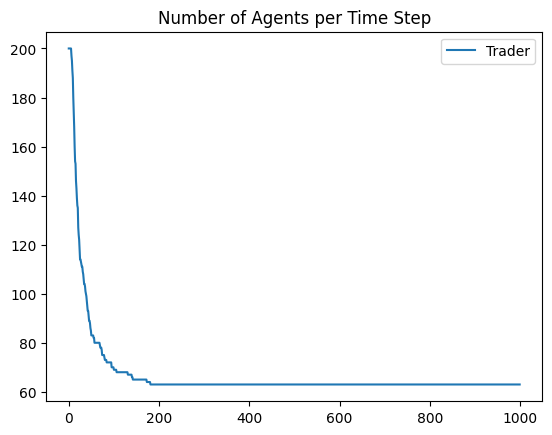

In [20]:
results.plot(y = "Trader", use_index = True, title="Number of Agents per Time Step")

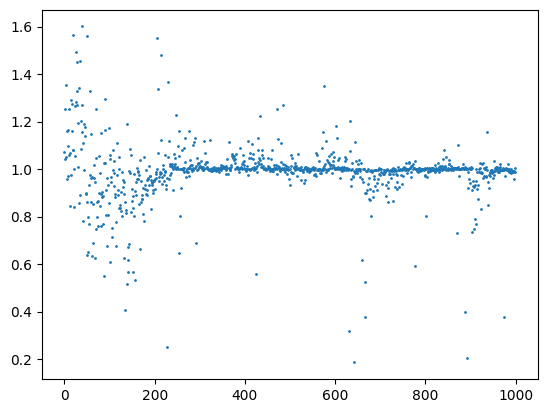

In [21]:
# Trade price per step

y = list(results["Price"])
x = range(1000)

plt.scatter(x, y, s = 1)

<BarContainer object of 990 artists>

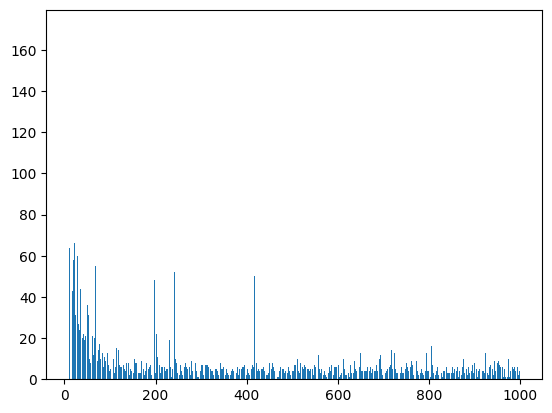

In [22]:
# Trade volume per step

plt.bar(results.index[10:], results["Trade Volume"][10:])

In [33]:
# Largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc).copy()

# Metrics
connectivity = nx.node_connectivity(G_lcc)
clustering = nx.average_clustering(G)
diameter = nx.diameter(G_lcc)
efficiency = nx.global_efficiency(G)

(connectivity, clustering, diameter, efficiency)

(1, 0.35648529513466176, 8, 0.43396226782610814)

(array([20., 20., 20., 19., 19., 19., 18., 19., 19., 19.]),
 array([4138. , 4157.9, 4177.8, 4197.7, 4217.6, 4237.5, 4257.4, 4277.3,
        4297.2, 4317.1, 4337. ]),
 <BarContainer object of 10 artists>)

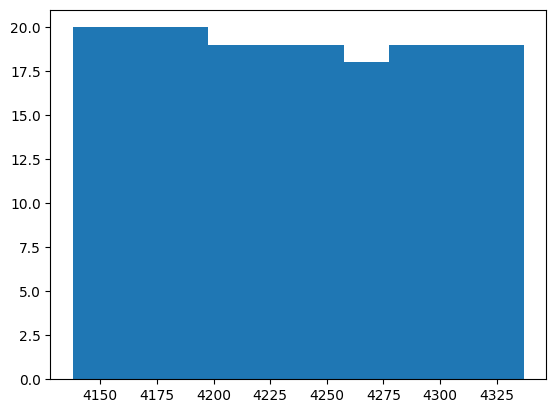

In [34]:
degree = [n for n,d in G.degree()]
plt.hist(degree)

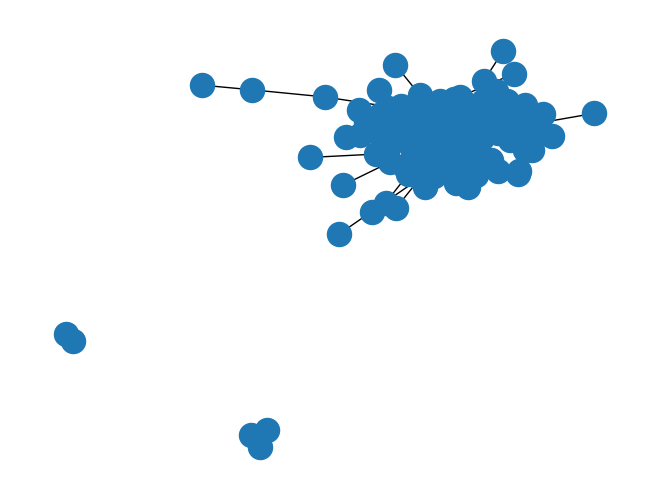

In [35]:
nx.draw(G)

# Batch Run and Analysis

In [36]:
params = {"width": 50, "height": 50, 
          "vision_min": range(1,3),
          "metabolism_max": [3,5]}

results_batch = mesa.batch_run(
    SugarscapeG1mt, 
    parameters = params,
    iterations = 1,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
    )

0it [00:00, ?it/s]


AttributeError: 'SugarscapeG1mt' object has no attribute 'running'